In [1]:
import numpy as np
import cv2
import skimage
from skimage import io
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage.morphology import reconstruction
from scipy import stats
from statistics import mean 
from collections import OrderedDict
#import plotly.graph_objects as go
import pandas as pd

#Optional modules
from skimage.feature import corner_harris, corner_subpix, corner_peaks
from skimage.transform import warp, AffineTransform

In [2]:
import watershed

In [3]:
img = cv2.imread('../example_images/sem_1.jpg',0)

In [8]:
def corner_detection(img, actual_len):
    """
    This function is used to find the length of each pixel in nm.
    The input should be the initial SEM image.
    actual_len should be in micrometer such as 2 um
    The unit of the output length_each_pixel is nm
    """
    def boundary_detection(img, thres = 20):
        '''
        thres: threshold to distinguish the scale bar background with particle background by grey scale
        for now only work for SEM img, needs update if apply to different imgs
        scan from upper to bottom, also needs update if need scan from left to right
        '''
        mode_list = []
        for line in range(len(img)):
            mode = stats.mode(img[line])
            mode_list.append(int(mode[0]))

            if line >= 1:
                mode_mean = mean(mode_list)
                if mode_mean - int(mode[0]) >= thres:
                    boundary = line
                    break

        return boundary
    
    def dilated_image(img,sigma):
        """
        filtering regional maxima to find bright features by 
        using gaussian filter and reconstruction
        simga: standard deviation for Gaussian kernel 
        """
        # Convert to float: Important for subtraction later which won't work with uint8
        img = gaussian_filter(img, sigma)
        seed = np.copy(img, sigma)
        seed[1:-1, 1:-1] = img.min()
        mask = img

        dilated = reconstruction(seed, mask, method='dilation')
        return dilated
    
    actual_len = actual_len*1000
    height = img.shape[0]
    width = img.shape[1]
    #find the bottom part of the SEM image. Here we used the return refunction 
    ime = img[boundary_detection(dilated_image(img,1)): , : ]
    
    # find the smallest area of interest
    boundary_v = []
    thres = 100
    for i in range(ime.shape[1]):
        if ime[:,i][0] > thres:
            boundary_v.append(i)
    
    #determine the smaller one of the scale bar region
    ime = img[boundary_detection(dilated_image(img,1)): , boundary_v[-1]+10: ]
    
    boundary_h = []
    for i in range(ime.shape[0]):
        if ime[i,:][0] > thres:
            boundary_h.append(i)
    ime = img[boundary_detection(dilated_image(img,1)):boundary_detection(dilated_image(img,1))+boundary_h[0] , boundary_v[-1]+10: ]
    
    tform = AffineTransform()
    image = warp(ime,tform.inverse)
    coords = corner_peaks(corner_harris(image))
    coords_subpix = corner_subpix(image, coords)
    
    #get the length of the scale bar
    #length_scale_bar = abs(coords[0][1] - coords[1][1])
    
    scales = []
    threshold = 500
    for i in range(len(coords)):
        for j in range(len(coords)):
            if j <= i:
                continue
            else:
                if coords[i][0] == coords[j][0]:
                    scale = abs(coords[i][1] - coords[j][1])
                    if scale > threshold:
                        scales.append((coords[i][0],scale))
                    else:
                        continue
                else:
                    continue
    scalebar = []
    for i in range(len(scales)):
        n_count = 0
        for j in range(len(scales)):
            if scales[i][0] == scales[j][0]:
                n_count += 1
            else:
                continue
        if n_count == 1:
            scalebar.append(scales[i][1])
        else:
            continue
    
    for i in range(len(scalebar)):
        num = scalebar.count(scalebar[i])
        if num >= 2:
            final_scale = scalebar[i]
        else:
            continue
    
    #get the length of the scale bar
    #length_scale_bar = abs(coords[0][1] - coords[1][1])
    #length of each pixel
    length_each_pixel = actual_len/final_scale
    
    # length of each pixel
    #length_each_pixel = actual_len/length_scale_bar
    
    
    #plot the figure with corner detected
    fig, ax = plt.subplots(figsize=(15,15))
    ax.imshow(image, cmap=plt.cm.gray)
    ax.plot(coords[:, 1], coords[:, 0], color='cyan', marker='o',
            linestyle='None', markersize=6)
    ax.plot(coords_subpix[:, 1], coords_subpix[:, 0], '+r', markersize=10)
    plt.show()
    return length_each_pixel

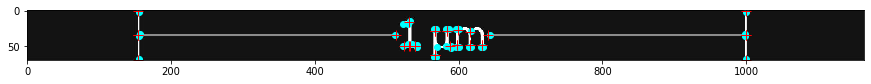

1.1848341232227488

In [9]:
length_each_pixel = corner_detection(img, 1)
length_each_pixel

In [ ]:
def boundary_detection(img, thres = 20, orient = 'horizontal'):
    '''
    thres: threshold to distinguish the scale bar background with particle background by grey scale
    for now only work for SEM img, needs update if apply to different imgs
    scan from upper to bottom, also needs update if need scan from left to right
    '''
    mode_list = []
    if orient == 'horizontal':
        img = img
    elif orient == 'vertical':
        img = img.T
    else:
        print('Please define proprate orientation!')
        
    for line in range(len(img)):
        mode = stats.mode(img[line])
        mode_list.append(int(mode[0]))
        
        if line >= 1:
            mode_mean = mean(mode_list)
            if mode_mean - int(mode[0]) >= thres:
                boundary = line
                break
        
    return boundary

In [ ]:
def img_pread(img, thres = 20, cut_orient = 'horizontal'):
    '''
    Pretreatment for the picture to get a dilated and boundary cutted image
    '''
    #Pretreatment for the boundary detection
    image = img
    image = gaussian_filter(image, 1)
    seed = np.copy(image)
    seed[1:-1, 1:-1] = image.min()
    mask = image
    dilated = reconstruction(seed, mask, method='dilation')
    
    image = mask - dilated
    if cut_orient == 'horizontal':
        bound = boundary_detection(dilated, cut_orient)
        img_c = image[:bound,:]
        img_c = img_c.astype(np.uint8)
    elif cut_orient == 'vertical':
        bound = boundary_detection(dilated, cut_orient)
        img_c = image[:,:bound]
        img_c = img_c.astype(np.uint8)
    else:
        img_c = image
    
    return img_c

In [ ]:
img_filtered = img_cutter(img)

In [ ]:
io.imshow(img_filtered)

In [ ]:
def peri_avg(contours):
    '''
    Assistant function for determine the average perimeter from all contours
    '''
    peri_c_tot = 0
    for c in contours:
        peri_c_tot += cv2.arcLength(c, True)
    peri_avg = peri_c_tot / len(contours)

    return peri_avg

In [ ]:
def contour_capture(img, 
                    #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9)), 
                    noise_factor = 0.25,
                    thresh_method = cv2.THRESH_BINARY,
                    area_thresh = 300):
    '''
    The function captures the contours from the given imgs
    Returns contours and dilated img
    '''
    #img dilation
    #dilated = cv2.dilate(img, kernel)
    _, threshold = cv2.threshold(img, img.max() * noise_factor, img.max(), thresh_method)
    contours, _=cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = [contour for contour in contours if cv2.contourArea(contour) >= area_thresh]
    
    return contours, img

In [ ]:
contours, dilated = contour_capture(img_filtered)

In [ ]:
def contour_summary(contours, hull = False):
    '''
    The function returns a summary based on the contour calculation
    '''
    contour_list = []
    
    for cnt in contours:
        '''
        More: add information for particle segmentation and area calculation
        output: shapetype, particle #, area of individuals
        '''
        if hull == False:
            contour_list.append(len(cnt))
        elif hull == True:
            approx = cv2.approxPolyDP(cnt, 0.01 * cv2.arcLength(cnt, True), True) #Tunning needed for the coeffecients
            hull = cv2.convexHull(approx)
            contour_list.append(len(hull))
    
    print(len(contour_list))
    plt.hist(contour_list)
    
    return

In [ ]:
contour_summary(contours)

In [ ]:
def shape_radar(contours, dilated, thresh_di = 1.08, thres_poly = 1.75):
    '''
    Takes input from contour_capture
    return a annotated img from setted threshold
    Model tunning is possible by using different predictions provided below
    '''

    #Create plot, copy the img and convert into color scale
    plt.figure(figsize=(20,16))
    dilated_c = dilated.copy()
    dilated_c = cv2.cvtColor(dilated_c,cv2.COLOR_GRAY2RGB)
    avg_c = peri_avg(contours)
    
    for c in contours:
        rect = cv2.minAreaRect(c)
        box = cv2.boxPoints(rect)
        box = np.int0(box)
        
        #Optional predictors
        area = cv2.contourArea(c)
        len_c = round(cv2.arcLength(c, True), 1)
        r_area_len = round((area/len_c),1)
        r_peri = len_c / avg_c

        if r_peri <= thresh_di:
            cv2.drawContours(dilated_c, [box], 0, (255, 255, 255), 3)
        elif r_peri > thresh_di and r_peri <= thres_poly:
            if area > 900:
                cv2.putText(dilated_c, 'dimer', (c[0][0][0], c[0][0][1]), cv2.FONT_HERSHEY_SIMPLEX,1,(255, 0, 0), 3)
                cv2.drawContours(dilated_c, [box], 0, (255, 0, 0), 3)
            else:
                cv2.drawContours(dilated_c, [box], 0, (255, 255, 255), 3)
        elif r_peri > thres_poly:
            cv2.putText(dilated_c, 'polymer', (c[0][0][0], c[0][0][1]), cv2.FONT_HERSHEY_SIMPLEX,1,(0, 255, 0), 3) 
            cv2.drawContours(dilated_c, [box], 0, (0, 255, 0), 3)

    return dilated_c


In [ ]:
img_shape = shape_radar(contours, dilated)

In [ ]:
plt.figure(figsize=(20,16))
io.imshow(img_shape)

# Adapted from partycool_my


## Plotly_trail: https://plot.ly/python/histograms/

In [ ]:
#Example of plotly

areas = [cv2.contourArea(contour) for contour in contours]
fig = go.Figure(data=[go.Histogram(x=areas)])
fig.show()

In [ ]:
def area_summary(contours):
    areas = [cv2.contourArea(contour) for contour in contours]
    #output of area will be a 2D array
    
    #plotting function
    plt.figure(figsize=(8, 6))
    _ = plt.hist(areas, bins=40, color='gray')
    plt.xlabel('Area of Au NRs (pixel^2)', fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    print("Total # of Au Particles :\n", len(areas))
    
    return

In [ ]:
area_summary(contours)

In [ ]:
#Information for position
def aspect_ratio(contours):
    aspectratio = []
    #Get rect area from the contours
    for i in range(0,len(contours)):
        x,y,w,h = cv2.boundingRect(contours[i])
        aspect_ratio = float(w)/h
        aspectratio.append(aspect_ratio)

    #plotting the aspect ratio of Au NRs
    plt.figure(figsize=(8, 6))
    _ = plt.hist(aspectratio, bins=40, color='gray')
    plt.xlabel('Aspect Ratio of Au NRs', fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    print("Total # of Au Particles :\n", len(aspectratio))
    
    return

In [ ]:
aspect_ratio(contours)

In [ ]:
def angle_summary(contours):
    #calculating angle of Au NRs (from Maxim page)
    dictionary = OrderedDict()
    com_arr = np.empty((0, 2))
    angles = []
    for cnt in contours:
        try:
            (com), _, angle = cv2.fitEllipse(cnt)
        except:
            continue
        com = np.array(com)
        com_arr = np.append(com_arr, [com], axis=0)
        angles.append(angle)
    
    #Plotting functions
    plt.figure(figsize=(8, 6))
    _ = plt.hist(angles, bins=40, color='gray')
    plt.xlabel('Au Particles Orientation (°)', fontsize=16)
    plt.ylabel('Count', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    print("Total # of Au Particles :\n", len(angles))
    
    return

In [ ]:
angle_summary(contours)

In [ ]:
def particle_summary(contours, thresh_mono = 30, thresh_di = 90, thres_poly = 130):
    '''
    returns a dataframe that summarized the particle information
    '''
    
    loc_x = []
    loc_y = []
    aspect_r = []
    area_l = []
    arealen_r = []
    category_l = []
    
    for c in contours:
        x,y,w,h = cv2.boundingRect(c)
        aspect_ratio = float(w)/h
        area = cv2.contourArea(c)
        r_area_len = round((area/len(c)),1)

        category = ''
        
        if len(c) <= thresh_di and len(c) > thresh_mono:
            if area > 1800:
                category = 'dimer'
            else:
                category = 'monomer'
        elif len(c) > thresh_di and len(c) <= thres_poly:
            category = 'dimer'
        elif len(c) > thres_poly:
            if r_area_len > 16.5:
                category = 'poly'
            else:
                category = 'dimer'

        loc_x.append(x)
        loc_y.append(y)
        aspect_r.append(aspect_ratio)
        area_l.append(area)
        arealen_r.append(r_area_len)
        category_l.append(category)

    result_dict = {'x' : loc_x, 
                   'y' : loc_y,
                   'aspect_ratio' : aspect_r,
                   'area' : area_l,
                   'areacontour_ratio' : arealen_r,
                   'category' : category_l}
                
    result_df = pd.DataFrame.from_dict(result_dict)
    
    return result_df


In [ ]:
df = particle_summary(contours)

In [ ]:
df.head()